# Week 9: Dropout

In [1]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



First, load in MNIST and display a character:

Image Size: (1, 28, 28)


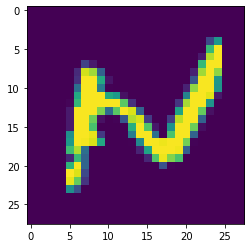

In [5]:
%matplotlib inline
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].squeeze().moveaxis(0, -1))

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


In [7]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [8]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [30]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [31]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [120,40,20,40,120] # this should be an array with units per hidden layer
num_classes = 10

vnn = VanillaNN(dataset[0][0].shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=120, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=20, out_features=40, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=40, out_features=120, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=120, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [32]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 10
lr = .0001

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [33]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/10, Iter: 100/480, Loss: 2.2971
Epoch: 1/10, Iter: 200/480, Loss: 2.1266
Epoch: 1/10, Iter: 300/480, Loss: 2.0438
Epoch: 1/10, Iter: 400/480, Loss: 1.8862
Epoch: 1/10, Iter: 480/480, Loss: 1.8459
Epoch 1 Train Accuracy: 64.07%
Epoch 1 Test Accuracy: 63.09%

Epoch: 2/10, Iter: 100/480, Loss: 1.7911
Epoch: 2/10, Iter: 200/480, Loss: 1.7421
Epoch: 2/10, Iter: 300/480, Loss: 1.7243
Epoch: 2/10, Iter: 400/480, Loss: 1.6906
Epoch: 2/10, Iter: 480/480, Loss: 1.6744
Epoch 2 Train Accuracy: 80.58%
Epoch 2 Test Accuracy: 80.06%

Epoch: 3/10, Iter: 100/480, Loss: 1.5928
Epoch: 3/10, Iter: 200/480, Loss: 1.6651
Epoch: 3/10, Iter: 300/480, Loss: 1.6590
Epoch: 3/10, Iter: 400/480, Loss: 1.6221
Epoch: 3/10, Iter: 480/480, Loss: 1.6237
Epoch 3 Train Accuracy: 85.40%
Epoch 3 Test Accuracy: 85.02%

Epoch: 4/10, Iter: 100/480, Loss: 1.6591
Epoch: 4/10, Iter: 200/480, Loss: 1.6017
Epoch: 4/10, Iter: 300/480, Loss: 1.5822
Epoch: 4/10, Iter: 400/480, Loss: 1.6171
Epoch: 4/10, Iter: 480/480, Loss: 1

In [34]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 90.18%


### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**

**TODO: How does dropout change the relationship of units in the network with their neighbors?**

In [35]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            nn.Dropout(dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too

                nn.Dropout(dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(dropout_values[-1]),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [40]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
hidden_layers = [1200,400,200]
dropout_probs = [.1,.5,.5]
num_classes = 10

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=784, out_features=1200, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1200, out_features=400, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=400, out_features=200, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=200, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [41]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 10
lr2 = .0001

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [42]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/10, Iter: 100/480, Loss: 2.1088
Epoch: 1/10, Iter: 200/480, Loss: 1.7971
Epoch: 1/10, Iter: 300/480, Loss: 1.6957
Epoch: 1/10, Iter: 400/480, Loss: 1.7255
Epoch: 1/10, Iter: 480/480, Loss: 1.6930
Epoch 1 Train Accuracy: 87.02%
Epoch 1 Test Accuracy: 86.89%

Epoch: 2/10, Iter: 100/480, Loss: 1.6108
Epoch: 2/10, Iter: 200/480, Loss: 1.6705
Epoch: 2/10, Iter: 300/480, Loss: 1.6160
Epoch: 2/10, Iter: 400/480, Loss: 1.6137
Epoch: 2/10, Iter: 480/480, Loss: 1.5660
Epoch 2 Train Accuracy: 90.86%
Epoch 2 Test Accuracy: 90.57%

Epoch: 3/10, Iter: 100/480, Loss: 1.5718
Epoch: 3/10, Iter: 200/480, Loss: 1.5576
Epoch: 3/10, Iter: 300/480, Loss: 1.5951
Epoch: 3/10, Iter: 400/480, Loss: 1.5787
Epoch: 3/10, Iter: 480/480, Loss: 1.5577
Epoch 3 Train Accuracy: 92.14%
Epoch 3 Test Accuracy: 91.80%

Epoch: 4/10, Iter: 100/480, Loss: 1.5419
Epoch: 4/10, Iter: 200/480, Loss: 1.5531
Epoch: 4/10, Iter: 300/480, Loss: 1.5471
Epoch: 4/10, Iter: 400/480, Loss: 1.5885
Epoch: 4/10, Iter: 480/480, Loss: 1

In [43]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 95.55%


In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**

THe training rate of the dropout model is slower than that of the Vanilla-net, this is likely due to the fact that dropout has to train 2^n networks for every n hidden layers.

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [44]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

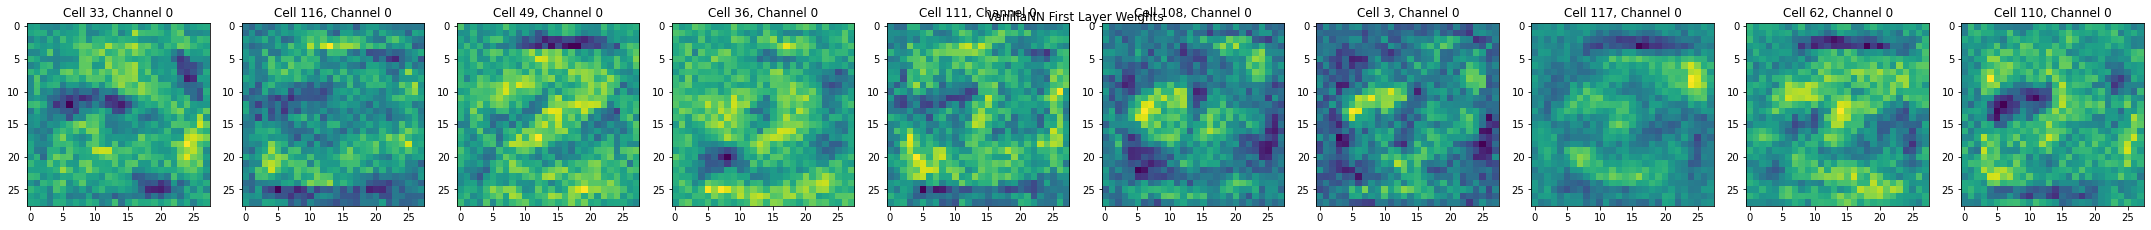

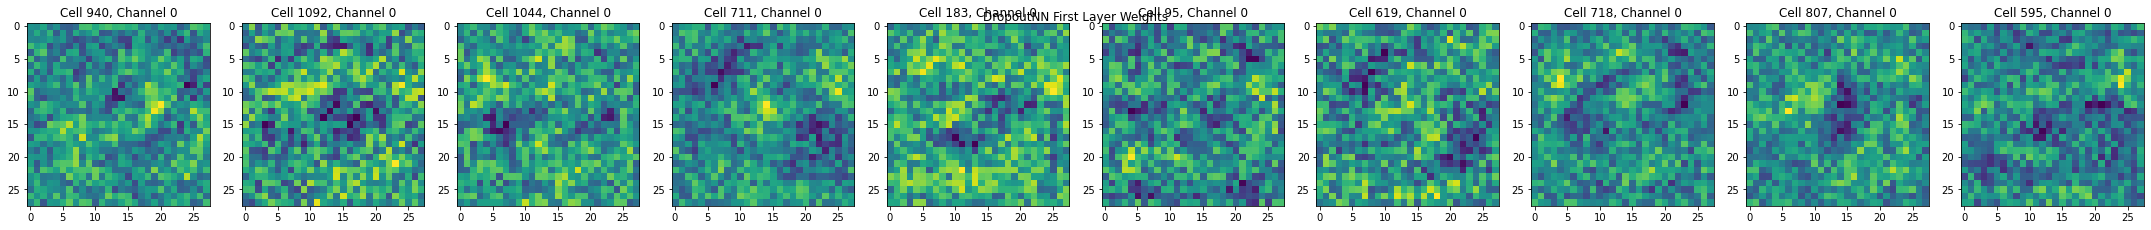

In [52]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [53]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    %matplotlib notebook
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    fig.show()
    
    return fig, axs, imgs, samples

In [61]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 4, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 4, 10, h, w, d, device, optimize_range=True)[0]

Working on image 1/10
Optimize Values After Layer Linear(in_features=20, out_features=40, bias=True), Node: 4
Epoch: 0/4500, Loss: 9.47
Epoch: 500/4500, Loss: 9.08
Epoch: 1000/4500, Loss: 1.07
Epoch: 1500/4500, Loss: 0.66
Epoch: 2000/4500, Loss: 0.14
Epoch: 2500/4500, Loss: -0.29
Epoch: 3000/4500, Loss: -0.51
Epoch: 3500/4500, Loss: -0.73
Epoch: 4000/4500, Loss: -0.91
Epoch: 4499/4500, Loss: -1.04
Working on image 2/10
Optimize Values After Layer Linear(in_features=20, out_features=40, bias=True), Node: 16
Epoch: 0/4500, Loss: 4.47
Epoch: 500/4500, Loss: 7.88
Epoch: 1000/4500, Loss: 2.87
Epoch: 1500/4500, Loss: 1.59
Epoch: 2000/4500, Loss: 0.88
Epoch: 2500/4500, Loss: 0.57
Epoch: 3000/4500, Loss: 0.30
Epoch: 3500/4500, Loss: 0.17
Epoch: 4000/4500, Loss: 0.05
Epoch: 4499/4500, Loss: -0.04
Working on image 3/10
Optimize Values After Layer Linear(in_features=20, out_features=40, bias=True), Node: 32
Epoch: 0/4500, Loss: 10.87
Epoch: 500/4500, Loss: 9.32
Epoch: 1000/4500, Loss: 4.97
Epoch:

<IPython.core.display.Javascript object>

Working on image 1/10
Optimize Values After Layer Linear(in_features=200, out_features=10, bias=True), Node: 3
Epoch: 0/4500, Loss: 35.62
Epoch: 500/4500, Loss: -19.60
Epoch: 1000/4500, Loss: -43.47
Epoch: 1500/4500, Loss: -64.66
Epoch: 2000/4500, Loss: -82.41
Epoch: 2500/4500, Loss: -89.90
Epoch: 3000/4500, Loss: -92.48
Epoch: 3500/4500, Loss: -93.72
Epoch: 4000/4500, Loss: -94.43
Epoch: 4499/4500, Loss: -94.84
Working on image 2/10
Optimize Values After Layer Linear(in_features=200, out_features=10, bias=True), Node: 7
Epoch: 0/4500, Loss: 15.65
Epoch: 500/4500, Loss: -18.83
Epoch: 1000/4500, Loss: -48.78
Epoch: 1500/4500, Loss: -72.24
Epoch: 2000/4500, Loss: -84.56
Epoch: 2500/4500, Loss: -86.52
Epoch: 3000/4500, Loss: -87.22
Epoch: 3500/4500, Loss: -87.57
Epoch: 4000/4500, Loss: -87.73
Epoch: 4499/4500, Loss: -87.84
Working on image 3/10
Optimize Values After Layer Linear(in_features=200, out_features=10, bias=True), Node: 2
Epoch: 0/4500, Loss: 25.64
Epoch: 500/4500, Loss: -22.17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [63]:
%matplotlib inline
vanilla_res

<IPython.core.display.Javascript object>

In [64]:
%matplotlib inline
dropout_res

<IPython.core.display.Javascript object>

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**
Java isn't cooperating with Google Colab so I have to infer from the key, it appears that the features that are being identified by the dropout nn are more focused (more central in the image, smaller gradient). This is likely because the dropout nn has to rely more on individual nodes identifying larger (more probable) features instead of making associations based of multiple nodes identifying strings of unimportant features.
**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**
Again, I can't get this to show up in Colab, but I suspect changing the layer we will see a larger variance between the dropout and vanilla net.